# Text Classification - Sentiment Analysis pada IMDB Movie Review

Sentiment Analysis adalah penambangan kontekstual teks yang mengidentifikasi dan mengekstrak informasi subjektif dalam sumber, dan membantu para pembisnis untuk memahami sentimen sosial dari merek, produk atau layanan mereka saat memantau percakapan online

### Data : https://www.kaggle.com/iarunava/imdb-movie-reviews-dataset
### Jumlah data : 20.000

## 1. Import Library 

In [2]:
import pandas as pd
import numpy as np
import nltk
import random
import pickle
import os
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from tqdm import tqdm_notebook as tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import models
from keras import layers

Using TensorFlow backend.


## 2. Import Data

In [3]:
path = "dataset/train/"
pos_reviews = []
neg_reviews = []
stop_words = set(stopwords.words("english"));

# ambil data review positif
for f_name in tqdm(os.listdir(path + "pos")) :
    with open(path + "pos/" + f_name, "rb") as f :
        pos_reviews.append(f.read().decode("utf-8"))
        
# ambil data review negatif
for f_name in tqdm(os.listdir(path + "neg")) :
    with open(path + "neg/" + f_name, "rb") as f :
        neg_reviews.append(f.read().decode("utf-8"))

# tampilkan panjang data
print(len(pos_reviews), len(neg_reviews))

# convert data ke dataframe
reviews = pd.concat([
    pd.DataFrame({"review":pos_reviews, "label":1}),
    pd.DataFrame({"review":neg_reviews, "label":0})
], ignore_index=True).sample(frac=1, random_state=1)

# hapus variable untuk menghemat memory
del pos_reviews
del neg_reviews

reviews.head()
        


10001 10001


,review,label
11457,This was awful. Andie Macdowell is a terrible ...,0
3830,Barbara Stanwyck gives this early Douglas Sirk...,1
18599,"The best thing about this movie was, uh, well,...",0
10039,"I grew up on Scooby Doo Where Are You, and I s...",0
1428,"I haven't read this book, but all through the ...",1


## 3. Data Preprocessing

Adapun proses yang dilakukan adalah :
- Lowercasing
- Stopword removal
- Stemming
- Punctuation removal
- Noise removal

In [4]:
def noise_removal(text):
    
    # menghilangkan html markup
    text=re.sub("(<.*?>)","",text)
    
    # menghilangkan non-ascii and digits
    text=re.sub("(\\W|\\d)"," ",text)
    
    # menghilangkan whitespace
    text=text.strip()
    return text


# inisialisasi porter stemmer untuk proses stemming
ps = PorterStemmer()

filtered_words = []
all_words = []

for index, row in tqdm(reviews.iterrows()) :
    # tokenisasi text menjadi token - token
    words = list(word_tokenize(row["review"]))
    for w in words :
        # membersihkan stopwords, menghilangkan punctuation dan melakukan lowercasing
        if (not w.lower() in stop_words and w.isalnum()) :
            # melakukan proses stemming dan noise removal
            filtered_word = noise_removal(ps.stem(w.lower()))
            filtered_words.append(filtered_word)
            all_words.append(filtered_word)
    reviews.loc[index, "review"] = " ".join(x for x in filtered_words)
    filtered_words = []

del filtered_words


reviews.head()

,review,label
11457,aw andi macdowel terribl actress wooden make r...,0
3830,barbara stanwyck give earli dougla soap kick n...,1
18599,best thing movi uh well ca think anyth bad scr...,0
10039,grew scoobi doo still love one favourit cartoo...,0
1428,read book movi awestruck one thought head vonn...,1


## 4. Visualisasi Data

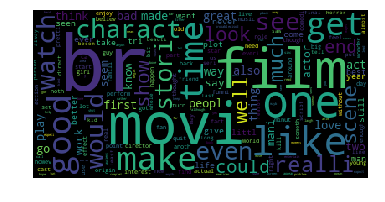

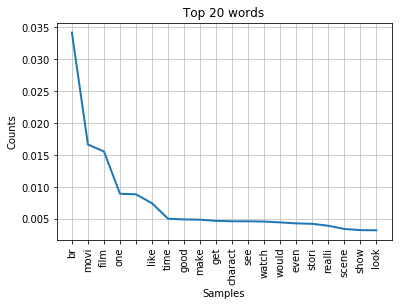

In [5]:
# fungsi untuk mem-plot frekuensi dist
def plot_freqdist(fd,
                       max_num=None,
                       cumulative=False,
                       title='Top 20 words',
                       linewidth=2):

    tmp = fd.copy()
    norm = fd.N()
    for key in tmp.keys():
        tmp[key] = float(fd[key]) / norm

    if max_num:
        tmp.plot(max_num, cumulative=cumulative,
                 title=title, linewidth=linewidth)
    else:
        tmp.plot(cumulative=cumulative, 
                 title=title, 
                 linewidth=linewidth)

    return


# ubah list word menjadi dict frekuensi
all_words = nltk.FreqDist(all_words)

# inisialisasi word cloud
wordcloud = WordCloud().generate_from_frequencies(all_words)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

plot_freqdist(all_words, 20)


## 5. Feature Selection

In [6]:
# inisialisasi tokenizer 
tokenizer = Tokenizer()
# membuat word_index dari review
tokenizer.fit_on_texts(reviews.review.values)

print(len(tokenizer.word_index))

# mengubah word menjadi sequence
seq = tokenizer.texts_to_sequences(reviews.review)

# mencari sequence terpanjang
max_len = max([len(review) for review in seq])
print(max_len)

# mempadding array sequence
seq = pad_sequences(seq, maxlen=max_len)

x_train = seq[:18000]
y_train = reviews.label.values[:18000]
x_test = seq[18000:]
y_test = reviews.label.values[18000:]

print(x_train[0], y_train[0])

del seq
del all_words

43686
1425
[   0    0    0 ... 1877 7863 4341] 0


## 6. Model Architecture

Model yang digunakan adalah Recurrent Neural Network/LSTM 

In [9]:
# model = models.Sequential()
# # Input - Layer
# model.add(layers.Dense(50, activation = "relu", input_shape=(max_len, )))
# # Hidden - Layers

# model.add(layers.Dense(100, activation = "relu"))
# model.add(layers.Dense(100, activation = "relu"))
# model.add(layers.Dense(100, activation = "relu"))
# model.add(layers.Dense(100, activation = "relu"))
# model.add(layers.Dense(100, activation = "relu"))
# model.add(layers.Dense(100, activation = "relu"))
# # Output- Layer
# model.add(layers.Dense(1, activation = "sigmoid"))
# model.summary()
# akurasi : 50%

from keras.layers import Embedding, LSTM, Dense, Dropout

embedding_size=32
model= models.Sequential()
# embedding layer
model.add(Embedding(43687, embedding_size, input_length=max_len))
model.add(LSTM(100))
# fungsi aktifasi : sigmoid
model.add(Dense(1, activation='sigmoid'))

print(model.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1425, 32)          1397984   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,451,285
Trainable params: 1,451,285
Non-trainable params: 0
_________________________________________________________________
None


## 7. Model Training

In [10]:
model.compile(
 optimizer = "adam",
 loss = "binary_crossentropy",
 metrics = ["accuracy"]
)

results = model.fit(
 x_train, y_train,
 epochs= 2,
 batch_size = 64,
 validation_data = (x_test, y_test)
)
print("Test-Accuracy:", np.mean(results.history["val_acc"]))

Train on 18000 samples, validate on 2002 samples
Epoch 1/2
12992/18000 [====================>.........] - ETA: 20:02 - loss: 0.6927 - acc: 0.54 - ETA: 16:52 - loss: 0.6923 - acc: 0.55 - ETA: 15:43 - loss: 0.6929 - acc: 0.53 - ETA: 15:01 - loss: 0.6927 - acc: 0.53 - ETA: 14:39 - loss: 0.6930 - acc: 0.51 - ETA: 14:33 - loss: 0.6932 - acc: 0.51 - ETA: 14:36 - loss: 0.6931 - acc: 0.51 - ETA: 14:38 - loss: 0.6932 - acc: 0.50 - ETA: 14:34 - loss: 0.6928 - acc: 0.51 - ETA: 14:29 - loss: 0.6930 - acc: 0.50 - ETA: 14:20 - loss: 0.6930 - acc: 0.50 - ETA: 14:11 - loss: 0.6930 - acc: 0.50 - ETA: 14:04 - loss: 0.6930 - acc: 0.50 - ETA: 13:58 - loss: 0.6931 - acc: 0.49 - ETA: 13:51 - loss: 0.6930 - acc: 0.49 - ETA: 13:46 - loss: 0.6929 - acc: 0.50 - ETA: 13:40 - loss: 0.6927 - acc: 0.51 - ETA: 13:35 - loss: 0.6926 - acc: 0.51 - ETA: 13:30 - loss: 0.6925 - acc: 0.51 - ETA: 13:25 - loss: 0.6925 - acc: 0.51 - ETA: 13:20 - loss: 0.6923 - acc: 0.52 - ETA: 13:15 - loss: 0.6922 - acc: 0.52 - ETA: 13:12 - l

13056/18000 [====================>.........] - ETA: 14:19 - loss: 0.3167 - acc: 0.85 - ETA: 14:24 - loss: 0.3119 - acc: 0.88 - ETA: 14:23 - loss: 0.2956 - acc: 0.89 - ETA: 14:17 - loss: 0.2654 - acc: 0.91 - ETA: 14:17 - loss: 0.2706 - acc: 0.90 - ETA: 14:14 - loss: 0.2727 - acc: 0.90 - ETA: 14:10 - loss: 0.2719 - acc: 0.90 - ETA: 14:07 - loss: 0.2725 - acc: 0.90 - ETA: 14:02 - loss: 0.2649 - acc: 0.90 - ETA: 14:01 - loss: 0.2775 - acc: 0.89 - ETA: 13:57 - loss: 0.2771 - acc: 0.89 - ETA: 13:54 - loss: 0.2725 - acc: 0.89 - ETA: 13:50 - loss: 0.2720 - acc: 0.89 - ETA: 13:47 - loss: 0.2605 - acc: 0.90 - ETA: 13:44 - loss: 0.2570 - acc: 0.90 - ETA: 13:41 - loss: 0.2533 - acc: 0.90 - ETA: 13:38 - loss: 0.2560 - acc: 0.90 - ETA: 13:36 - loss: 0.2709 - acc: 0.89 - ETA: 13:30 - loss: 0.2677 - acc: 0.89 - ETA: 13:27 - loss: 0.2709 - acc: 0.89 - ETA: 13:23 - loss: 0.2673 - acc: 0.89 - ETA: 13:20 - loss: 0.2634 - acc: 0.89 - ETA: 13:17 - loss: 0.2602 - acc: 0.89 - ETA: 13:13 - loss: 0.2568 - acc: 

18000/18000 [==============================] - ETA: 3:55 - loss: 0.2196 - acc: 0.916 - ETA: 3:52 - loss: 0.2198 - acc: 0.915 - ETA: 3:49 - loss: 0.2199 - acc: 0.915 - ETA: 3:46 - loss: 0.2202 - acc: 0.915 - ETA: 3:43 - loss: 0.2202 - acc: 0.915 - ETA: 3:40 - loss: 0.2207 - acc: 0.915 - ETA: 3:37 - loss: 0.2212 - acc: 0.915 - ETA: 3:34 - loss: 0.2222 - acc: 0.915 - ETA: 3:31 - loss: 0.2218 - acc: 0.915 - ETA: 3:27 - loss: 0.2218 - acc: 0.915 - ETA: 3:24 - loss: 0.2219 - acc: 0.915 - ETA: 3:21 - loss: 0.2221 - acc: 0.915 - ETA: 3:18 - loss: 0.2220 - acc: 0.915 - ETA: 3:15 - loss: 0.2218 - acc: 0.915 - ETA: 3:12 - loss: 0.2225 - acc: 0.915 - ETA: 3:09 - loss: 0.2222 - acc: 0.915 - ETA: 3:06 - loss: 0.2225 - acc: 0.915 - ETA: 3:03 - loss: 0.2226 - acc: 0.915 - ETA: 3:00 - loss: 0.2225 - acc: 0.915 - ETA: 2:57 - loss: 0.2221 - acc: 0.915 - ETA: 2:53 - loss: 0.2219 - acc: 0.915 - ETA: 2:50 - loss: 0.2225 - acc: 0.915 - ETA: 2:47 - loss: 0.2221 - acc: 0.915 - ETA: 2:44 - loss: 0.2218 - acc: 0

## Kesimpulan

Dengam menggunakan model RNN/LSTM, akurasi yang didapatkan adalah : 85.43%